# Naive Bayes From Scratch

In an effort to reinforce my understanding of statistical decision making, I wanted to build a naive bayes classifier without using a stats library like Sklearn. In the code that follows, you can see the results of my efforts. I was able to build a classifier that performs as well as sklearn's GaussianNB classifer.  

## Importing and Cleaning the Data

I'm using data from the MLB Stats API that I've previously collected for a [seperate, ongoing project](https://github.com/schlinkertc/MLB_Analysis). For this example, we'll use the end speed and spin rate of mlb pitches to classify them as either a fastball or not a fastball. End speed refers to the velocity of the ball as it crosses the plate, and [spin rate](http://m.mlb.com/glossary/statcast/spin-rate) refers to the revolutions per minute of the ball after it's released.

If you want to use this data for your own purposes, you can find it on [GitHub](https://github.com/schlinkertc/Pitch-Classification).

In [25]:
import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

In [26]:
path = os.getcwd().strip('Bayes')+'FetchData/datasets/'

df = pd.read_csv(path+'pitchSpeed_spinRate.csv')
print(df.shape)
df.dropna(inplace=True)

df.head()

(1910986, 3)


,endSpeed,spinRate,pitchType
0,87.7,1926.0,Four-Seam Fastball
1,89.0,1872.0,Four-Seam Fastball
2,83.9,1661.0,Changeup
3,88.3,1934.0,Two-Seam Fastball
4,88.9,1997.0,Four-Seam Fastball


Certain pitches aren't useful for our purposes. 
- 'Automatic Balls' are not actually thrown. They're used when a pitcher strategically decides to [intentionally walk](https://en.wikipedia.org/wiki/Intentional_base_on_balls) a batter
- A ['Pitchout'](https://en.wikipedia.org/wiki/Pitchout) is a throw away pitch used when you want to catch a runner stealing 
- An Eephus is a [rare and hilarious](https://www.youtube.com/watch?v=VfWXADedncM) trick pitch

In [27]:
# drop outlier pitch types
pitchTypes_toDrop = ['Automatic Ball','Pitchout','Eephus']
i = df[df['pitchType'].isin(pitchTypes_toDrop)].index
df.drop(index=i,inplace=True)

df.shape

To make things simpler, we're only going to classify 'fastball' vs 'not fastball'.

In [6]:
def is_fastball(x):
    if 'Fastball' in x['pitchType']:
        return 'fastball'
    else:
        return 'not fastball'
df['is_fastball'] = df.apply(lambda x: is_fastball(x),axis=1)
df['is_fastball'].value_counts()

not fastball    974122
fastball        873880
Name: is_fastball, dtype: int64

### Explore the Data

First, we want to see if our features our normally distributed. That way, we can use the Gaussian Probability Density function to estimate the liklihood of observing a particular value in our feature vectors. 

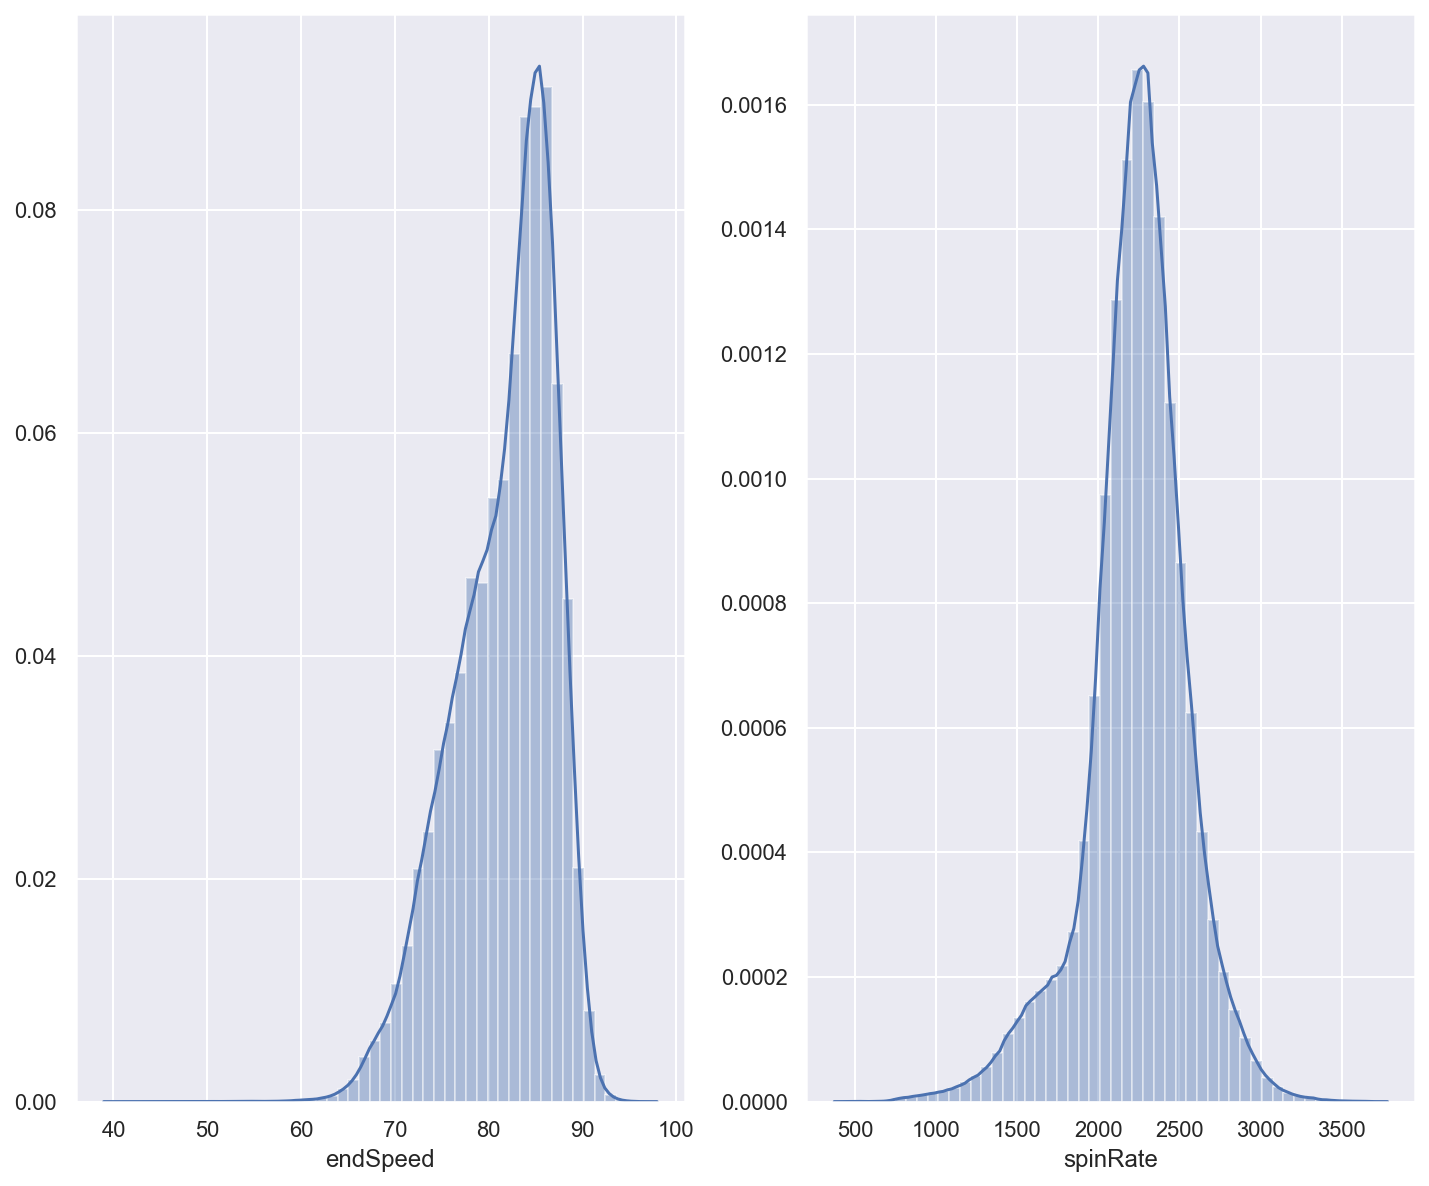

In [29]:
f, axes = plt.subplots(1,2)
sns.distplot(df['endSpeed'],ax=axes[0])
sns.distplot(df['spinRate'],ax=axes[1])

Next, we can use a simple scatter plot to see if our features provide reasonable seperation between their respective classes.

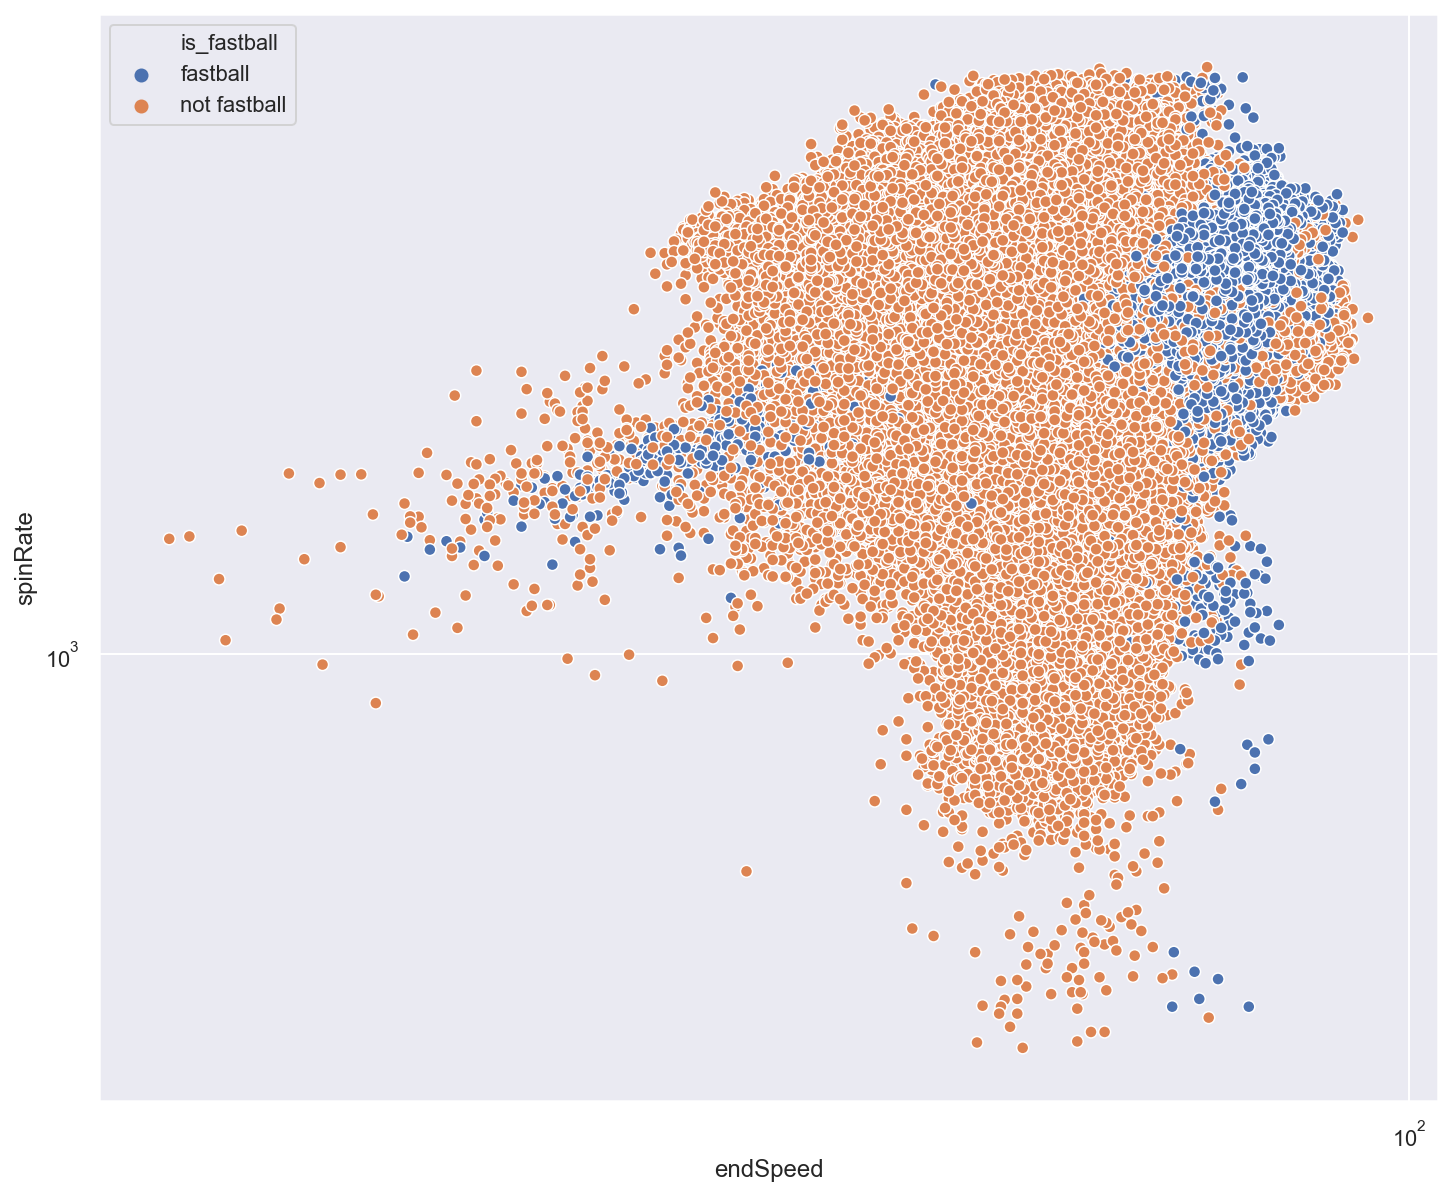

In [8]:
fig, ax = plt.subplots()
ax.set(xscale='symlog',yscale='symlog')
sns.scatterplot(x=df['endSpeed'],y=df['spinRate'],hue=df['is_fastball'])

## Building our Classifier

![bayes_image.png](https://miro.medium.com/max/768/1*zPseemLGYHMS8M0phAhhoA.png)

'A' is our class value (fastball vs not fastball) and 'B' are our predictive features (end speed and spin rate)

### Breaking Down Bayes' Theorem

We need to calculate the probability for each class, fastball and not fastball, given our input data. Then, we choose the class that has the highest probability. We can ignore the denominator in this case. We only care about which probability is higher, and the denominator would be same value in both equations.

P(A) is our "prior" probability, and it's very easy to calculate. In our case, it's the number of fastballs (or non-fastballs) divided by the total pitches in the dataset. 

In [33]:
def is_fastball(x):
    if 'Fastball' in x['pitchType']:
        return 'fastball'
    else:
        return 'not fastball'
df['is_fastball'] = df.apply(lambda x: is_fastball(x),axis=1)
df['is_fastball'].value_counts()

not fastball    974122
fastball        873880
Name: is_fastball, dtype: int64

P(B|A) is our "liklihood", and that's a little more complicated. We need to determine the liklihood of observing oura particular value in our input vectors given a class value. Since our features our roughly normally distributed, we can use the Gaussian Probability Density Function. We only need the mean and standard deviation of a class vector the calculate liklihood.

In [30]:
# Create a function that calculates p(x | y):
def likelihood(x,mean,sigma):
    return np.exp(-(x-mean)**2/(2*sigma**2))*(1/(np.sqrt(2*np.pi)*sigma))

### Building our Classifier

This is a factory function that takes in our input vectors (X) and outputs (Y) and calculates the figures we need to classify a pitch. As stated above, we'll need prior probabilites as well as the mean and the standard deviation for our input feature vectors seperated by class value. The function returns another function. The returning function will only take in the input vectors, and it will return probabilities for each class as a dictionary of NumPy arrays.

In [56]:
def fit(X,Y):
    classes = np.unique(Y)
    num_predictors = X.shape[1]
    
    # params dictionary will store the values we need to predict
    params = {}
    for G in classes:
        class_params = []
        for i in range(num_predictors):
            feature_params = {}
            feature_params['prior'] = len(np.where(Y==G)[0])/len(Y)
            feature_params["mean"] = X[np.where(Y==G)][:,i].mean()
            feature_params["sigma"] = X[np.where(Y==G)][:,i].std()
            
            class_params.append(feature_params)
        params[G]=class_params
    
    # The function that is returned from the factory function retains scope. 
    # So it knows the values calculated above
    def predict(X_test):
        class_probabilites = {}
        for G in classes:
            liklihoods = np.empty(X_test.shape)
            for i in range(liklihoods.shape[1]):
                liklihoods[:,i] = likelihood(X_test[:,i],params[G][i]['mean'],params[G][i]['sigma'])
            out = np.prod(liklihoods,axis=1)
            out*=params[G][0]['prior']
            class_probabilites[G]=out
        return class_probabilites
                
    return predict

In [63]:
y = df['is_fastball'].to_numpy()
x = df[['endSpeed','spinRate']].to_numpy()
nb = fit(x,y)
nb

<function __main__.fit.<locals>.predict(X_test)>

In [64]:
predict = nb(x)
predict

{'fastball': array([2.27745304e-05, 7.18554093e-06, 6.92096463e-07, ...,
        9.13635997e-05, 9.01459308e-05, 1.26118320e-04]),
 'not fastball': array([5.06947230e-06, 2.62086247e-06, 8.21903785e-06, ...,
        1.17705429e-05, 1.24653868e-05, 1.38775678e-05])}

In [67]:
predicted_fastballs = predict['fastball']>predict['not fastball']
predicted_fastballs

array([ True,  True, False, ...,  True,  True,  True])

## Evaluating the Results

First, we'll use sklearn's classification report to get a high level summary of how our classifier did when it was trained on the whole dataset.

In [68]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(y == "fastball",predicted_fastballs,output_dict=True))

,False,True,accuracy,macro avg,weighted avg
precision,0.921015,0.793438,0.850679,8.572267e-01,8.606868e-01
recall,0.783955,0.925057,0.850679,8.545062e-01,8.506793e-01
f1-score,0.846976,0.854207,0.850679,8.505918e-01,8.503957e-01
support,974122.000000,873880.000000,0.850679,1.848002e+06,1.848002e+06


It looks pretty good! But just to make sure, let's split the data into train and test sets and compare the results versus sklearn.

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
#split the data
X_train,X_test,y_train,y_test = train_test_split(x,y, test_size=.3, random_state=0)

#fit
gnb = GaussianNB()
sk_fit = gnb.fit(X_train,y_train)
#predict
sk_y_pred = sk_fit.predict(X_test)

pd.DataFrame(classification_report(y_test,sk_y_pred,output_dict=True))

,fastball,not fastball,accuracy,macro avg,weighted avg
precision,0.793633,0.920872,0.850783,0.857252,0.860725
recall,0.924814,0.784416,0.850783,0.854615,0.850783
f1-score,0.854217,0.847184,0.850783,0.850700,0.850508
support,262070.000000,292331.000000,0.850783,554401.000000,554401.000000


In [72]:
#fit
my_fit = fit(X_train,y_train)

#predict
my_y_pred = my_fit(X_test)
my_y_pred = my_y_pred['fastball']>my_y_pred['not fastball']

pd.DataFrame(classification_report(y_test=='fastball',my_y_pred,output_dict=True))

,False,True,accuracy,macro avg,weighted avg
precision,0.920872,0.793633,0.850783,0.857252,0.860725
recall,0.784416,0.924814,0.850783,0.854615,0.850783
f1-score,0.847184,0.854217,0.850783,0.850700,0.850508
support,292331.000000,262070.000000,0.850783,554401.000000,554401.000000


## Conclusion

Our homemade Bayes' classifier returned the same result as sklearn, so I'm happy with this. It works reasonably well in this situation because our input features are roughly normally distributed, and there's good seperation between class values. Naive Bayes is also good choice in this particular situation because of how many records we have. Naive Bayes doesn't take very long to produce results because we only need a few data points (mean, standard deviation, and prior probabilities) upon which to form our predictions.  